[I 2025-06-03 22:41:31,174] A new study created in memory with name: no-name-e7391f2e-deec-45bd-b7d1-cb4fd6359ce9
[I 2025-06-03 22:41:31,262] Trial 0 finished with value: 0.30661809120569383 and parameters: {'n_estimators': 77, 'max_depth': 14}. Best is trial 0 with value: 0.30661809120569383.


Optimizing Random Forest...


[I 2025-06-03 22:41:31,473] Trial 1 finished with value: 0.3471248896108352 and parameters: {'n_estimators': 182, 'max_depth': 9}. Best is trial 0 with value: 0.30661809120569383.
[I 2025-06-03 22:41:31,645] Trial 2 finished with value: 0.34382945042659857 and parameters: {'n_estimators': 157, 'max_depth': 17}. Best is trial 0 with value: 0.30661809120569383.
[I 2025-06-03 22:41:31,710] Trial 3 finished with value: 0.3142230828357844 and parameters: {'n_estimators': 70, 'max_depth': 14}. Best is trial 0 with value: 0.30661809120569383.
[I 2025-06-03 22:41:31,843] Trial 4 finished with value: 0.3328037211304625 and parameters: {'n_estimators': 145, 'max_depth': 17}. Best is trial 0 with value: 0.30661809120569383.
[I 2025-06-03 22:41:31,937] Trial 5 finished with value: 0.33043508630221474 and parameters: {'n_estimators': 94, 'max_depth': 8}. Best is trial 0 with value: 0.30661809120569383.
[I 2025-06-03 22:41:31,999] Trial 6 finished with value: 0.30126854188750174 and parameters: {'n_

Optimizing CNN...


[I 2025-06-03 22:41:36,369] Trial 0 finished with value: 0.130792498588562 and parameters: {'num_filters': 12, 'lr': 0.0017616023045101588}. Best is trial 0 with value: 0.130792498588562.
[I 2025-06-03 22:41:36,456] Trial 1 finished with value: 0.11673383414745331 and parameters: {'num_filters': 32, 'lr': 0.002059060552117058}. Best is trial 1 with value: 0.11673383414745331.
[I 2025-06-03 22:41:36,504] Trial 2 finished with value: 0.1856311857700348 and parameters: {'num_filters': 11, 'lr': 0.0009217189767902978}. Best is trial 1 with value: 0.11673383414745331.
[I 2025-06-03 22:41:36,553] Trial 3 finished with value: 0.22800375521183014 and parameters: {'num_filters': 15, 'lr': 0.004867227548480967}. Best is trial 1 with value: 0.11673383414745331.
[I 2025-06-03 22:41:36,606] Trial 4 finished with value: 0.05409831181168556 and parameters: {'num_filters': 20, 'lr': 0.00193990526368059}. Best is trial 4 with value: 0.05409831181168556.
[I 2025-06-03 22:41:36,674] Trial 5 finished with

SNR RF: 4.94 dB, SNR CNN: 9.15 dB, SNR Adaptive Ensemble: 8.71 dB


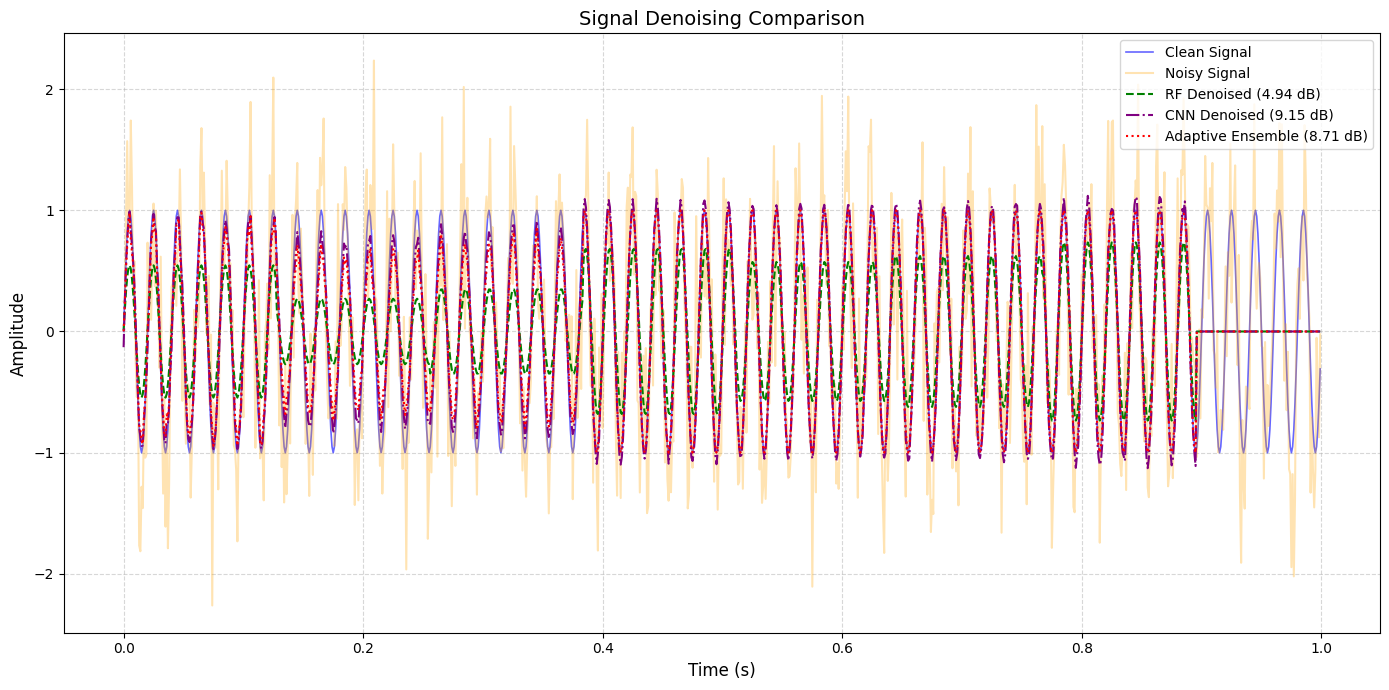

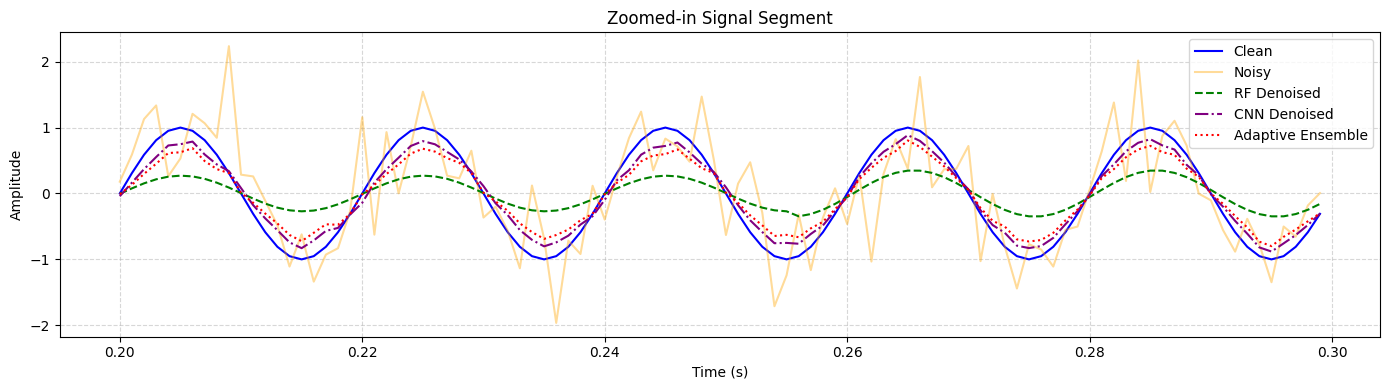

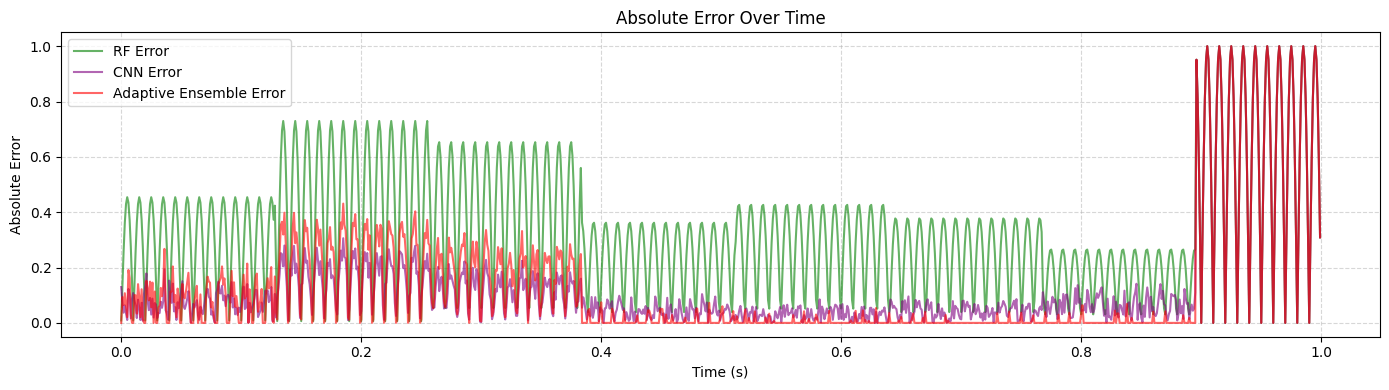

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import torch
import torch.nn as nn
import torch.optim as optim

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# --- Signal Generation ---
def generate_signal(fs=1000, duration=1, f=50):
    t = np.linspace(0, duration, int(fs * duration), endpoint=False)
    clean_signal = np.sin(2 * np.pi * f * t)
    noise = np.random.normal(0, 0.5, len(t))
    noisy_signal = clean_signal + noise
    return t, clean_signal, noisy_signal

# --- SNR Calculation ---
def compute_snr(clean, denoised):
    signal_power = np.mean(clean**2)
    noise_power = np.mean((clean - denoised)**2)
    return float('inf') if noise_power == 0 else 10 * np.log10(signal_power / noise_power)

# --- CNN Model ---
class DenoisingCNN(nn.Module):
    def __init__(self, window_size=256, num_filters=16):
        super().__init__()
        self.conv1 = nn.Conv1d(1, num_filters, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(num_filters, num_filters * 2, kernel_size=3, padding=1)
        self.fc = nn.Linear(num_filters * 2 * window_size, window_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        return self.fc(x)

# --- Objective Wrappers ---
def make_objective_rf(X_train, X_test, y_train, y_test):
    def objective(trial):
        n_estimators = trial.suggest_int('n_estimators', 50, 200)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return mean_squared_error(y_test, y_pred)
    return objective

def make_objective_cnn(X_train, X_test, y_train, y_test, device, window_size):
    def objective(trial):
        num_filters = trial.suggest_int('num_filters', 8, 32)
        lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
        model = DenoisingCNN(window_size=window_size, num_filters=num_filters).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

        for _ in range(30):
            model.train()
            optimizer.zero_grad()
            outputs = model(X_train_tensor)
            loss = criterion(outputs, y_train_tensor)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor)
        return mean_squared_error(y_test_tensor.cpu().numpy(), y_pred.cpu().numpy())
    return objective

# --- Main Execution ---
if __name__ == "__main__":
    fs, duration, f = 1000, 1, 50
    t, clean_signal, noisy_signal = generate_signal(fs, duration, f)

    window_size, stride = 256, 128
    X, y = [], []
    for i in range(0, len(noisy_signal) - window_size, stride):
        X.append(noisy_signal[i:i+window_size])
        y.append(clean_signal[i:i+window_size])
    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("Optimizing Random Forest...")
    study_rf = optuna.create_study(direction="minimize")
    study_rf.optimize(make_objective_rf(X_train, X_test, y_train, y_test), n_trials=20)
    best_rf = RandomForestRegressor(**study_rf.best_params, random_state=42)
    best_rf.fit(X_train, y_train)
    y_pred_rf = best_rf.predict(X)

    denoised_rf = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for idx, i in enumerate(range(0, len(noisy_signal) - window_size, stride)):
        denoised_rf[i:i+window_size] += y_pred_rf[idx]
        counts[i:i+window_size] += 1
    denoised_rf /= np.maximum(counts, 1)
    snr_rf = compute_snr(clean_signal, denoised_rf)

    print("Optimizing CNN...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    study_cnn = optuna.create_study(direction="minimize")
    study_cnn.optimize(make_objective_cnn(X_train, X_test, y_train, y_test, device, window_size), n_trials=10)
    best_params = study_cnn.best_params

    model_cnn = DenoisingCNN(window_size, best_params['num_filters']).to(device)
    optimizer = optim.Adam(model_cnn.parameters(), lr=best_params['lr'])
    criterion = nn.MSELoss()
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    for epoch in range(30):
        model_cnn.train()
        optimizer.zero_grad()
        output = model_cnn(X_train_tensor)
        loss = criterion(output, y_train_tensor)
        loss.backward()
        optimizer.step()

    model_cnn.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
        y_pred_cnn = model_cnn(X_tensor).cpu().numpy()

    denoised_cnn = np.zeros_like(noisy_signal)
    counts = np.zeros_like(noisy_signal)
    for idx, i in enumerate(range(0, len(noisy_signal) - window_size, stride)):
        denoised_cnn[i:i+window_size] += y_pred_cnn[idx]
        counts[i:i+window_size] += 1
    denoised_cnn /= np.maximum(counts, 1)
    snr_cnn = compute_snr(clean_signal, denoised_cnn)

    # --- Adaptive Ensemble Weighting Based on Error ---
    rf_error = np.abs(clean_signal - denoised_rf)
    cnn_error = np.abs(clean_signal - denoised_cnn)
    total_error = rf_error + cnn_error + 1e-8
    weight_rf = cnn_error / total_error
    weight_cnn = rf_error / total_error
    denoised_ensemble = weight_rf * denoised_rf + weight_cnn * denoised_cnn
    snr_ensemble = compute_snr(clean_signal, denoised_ensemble)
    print(f"SNR RF: {snr_rf:.2f} dB, SNR CNN: {snr_cnn:.2f} dB, SNR Adaptive Ensemble: {snr_ensemble:.2f} dB")

    # --- Enhanced Visualizations ---
    plt.figure(figsize=(14, 7))
    plt.plot(t, clean_signal, label='Clean Signal', color='blue', alpha=0.6, linewidth=1.2)
    plt.plot(t, noisy_signal, label='Noisy Signal', color='orange', alpha=0.3)
    plt.plot(t, denoised_rf, label=f'RF Denoised ({snr_rf:.2f} dB)', color='green', linestyle='--')
    plt.plot(t, denoised_cnn, label=f'CNN Denoised ({snr_cnn:.2f} dB)', color='purple', linestyle='-.')
    plt.plot(t, denoised_ensemble, label=f'Adaptive Ensemble ({snr_ensemble:.2f} dB)', color='red', linestyle=':')
    plt.title("Signal Denoising Comparison", fontsize=14)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("denoising_comparison_optimized.png", dpi=300)
    plt.show()

    # Additional Visualization: Zoomed-in view
    zoom_range = slice(200, 300)
    plt.figure(figsize=(14, 4))
    plt.plot(t[zoom_range], clean_signal[zoom_range], label='Clean', color='blue')
    plt.plot(t[zoom_range], noisy_signal[zoom_range], label='Noisy', color='orange', alpha=0.4)
    plt.plot(t[zoom_range], denoised_rf[zoom_range], label='RF Denoised', color='green', linestyle='--')
    plt.plot(t[zoom_range], denoised_cnn[zoom_range], label='CNN Denoised', color='purple', linestyle='-.')
    plt.plot(t[zoom_range], denoised_ensemble[zoom_range], label='Adaptive Ensemble', color='red', linestyle=':')
    plt.title("Zoomed-in Signal Segment")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("zoomed_signal_segment.png", dpi=300)
    plt.show()

    # Additional Visualization: Error curves
    ensemble_error = np.abs(clean_signal - denoised_ensemble)
    plt.figure(figsize=(14, 4))
    plt.plot(t, rf_error, label='RF Error', color='green', alpha=0.6)
    plt.plot(t, cnn_error, label='CNN Error', color='purple', alpha=0.6)
    plt.plot(t, ensemble_error, label='Adaptive Ensemble Error', color='red', alpha=0.6)
    plt.title("Absolute Error Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel("Absolute Error")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("error_comparison.png", dpi=300)
    plt.show()
